In [56]:
import pandas as pd
import numpy as np
import pickle
import json
import numpy as np
import regex as re
import matplotlib.pyplot as plt
from scipy.sparse import save_npz, load_npz
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC  
from sklearn.naive_bayes import MultinomialNB  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BW\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BW\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# load the dataset
data = pd.read_csv('output.csv')

In [3]:
data.head()

,id,app_id,content,author_id,is_positive
0,181331361,100,At least its a counter strike -1/100,76561199556485100,Negative
1,180872601,100,Uh... So far my playthrough has not been great...,76561199230620391,Negative
2,177836246,100,Better mechanics than cs2,76561198417690647,Negative
3,177287444,100,buggy mess and NOT fun to play at all,76561199077268730,Negative
4,176678990,100,"Whoever came up with this, is gonna fucking ge...",76561199104544266,Negative


In [4]:
data = data[['content', 'is_positive']]
data.head()

,content,is_positive
0,At least its a counter strike -1/100,Negative
1,Uh... So far my playthrough has not been great...,Negative
2,Better mechanics than cs2,Negative
3,buggy mess and NOT fun to play at all,Negative
4,"Whoever came up with this, is gonna fucking ge...",Negative


- Checking missing values

In [5]:
data['content'].isnull().sum()

428

In [6]:
data['is_positive'].isnull().sum()

0

- Pre-processing and cleaning

In [7]:
# dropping rows with missing values
data.dropna(inplace=True)

In [8]:
data['content'].isnull().sum()

0

In [9]:
data['is_positive'].value_counts()

is_positive
Positive    102377
Negative     98346
Name: count, dtype: int64

- Classes is not heaily imbalanced so no imbalance handling techniques are needed.

In [10]:
## 1. Lower all the cases
data['content'] = data['content'].str.lower()
data['content']

0                      at least its a counter strike -1/100
1         uh... so far my playthrough has not been great...
2                                 better mechanics than cs2
3                     buggy mess and not fun to play at all
4         whoever came up with this, is gonna fucking ge...
                                ...                        
201146                    this trash for sick anime clowns!
201147                                    not noob friendly
201148                        total trash for anime clowns!
201149    unplayable. it keeps trying to update but then...
201150                                      bring back csgo
Name: content, Length: 200723, dtype: object

In [ ]:
## Removing special characters
data['content'] = data['content'].apply(lambda x:re.sub('[^a-zA-Z0-9]+', ' ', x))

In [ ]:
data['content']

0                       at least its a counter strike 1 100
1         uh so far my playthrough has not been great gl...
2                                 better mechanics than cs2
3                     buggy mess and not fun to play at all
4         whoever came up with this is gonna fucking get...
                                ...                        
201146                    this trash for sick anime clowns 
201147                                    not noob friendly
201148                        total trash for anime clowns 
201149    unplayable it keeps trying to update but then ...
201150                                      bring back csgo
Name: content, Length: 200723, dtype: object

In [ ]:
data['content'].head()

0                  at least its a counter strike 1 100
1    uh so far my playthrough has not been great gl...
2                            better mechanics than cs2
3                buggy mess and not fun to play at all
4    whoever came up with this is gonna fucking get...
Name: content, dtype: object

In [ ]:
## Remove the stopwords
data['content'] = data['content'].apply(lambda x: " ".join([y for y in x.split() if y.lower() not in stopwords.words('english')]))

In [ ]:
## Remove urls 
data['content'] = data['content'].apply(lambda x: re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', ' ', str(x)))

In [ ]:
# Remove html tags
from bs4 import BeautifulSoup
data['content'] = data['content'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())

In [ ]:
data['content'].head(10)

0                           least counter strike 1 100
1    uh far playthrough great glitched textures con...
2                                 better mechanics cs2
3                                  buggy mess fun play
4    whoever came gonna fucking get negative review...
5    every enemy grandmother aimbot even funny died...
6                                                    l
7    counter strike condition zero deleted scenes 2...
8    review deleted scenes game pretty fun plays li...
9                                         many enemies
Name: content, dtype: object

- after pre-processing some reviews became too short like the above 6th review. its just 'l'.

In [ ]:
## Filtering (keeps only those reviews where the length is more than 2 characters)
data = data[data['content'].str.strip().str.len() > 2]

In [ ]:
data.head(10)

,content,is_positive
0,least counter strike 1 100,Negative
1,uh far playthrough great glitched textures con...,Negative
2,better mechanics cs2,Negative
3,buggy mess fun play,Negative
4,whoever came gonna fucking get negative review...,Negative
5,every enemy grandmother aimbot even funny died...,Negative
7,counter strike condition zero deleted scenes 2...,Negative
8,review deleted scenes game pretty fun plays li...,Negative
9,many enemies,Negative
11,weird,Negative


In [ ]:
## Encoding target feature
data['is_positive'] = data['is_positive'].map({'Negative': 0, 'Positive': 1})

In [ ]:
data.head()

,content,is_positive
0,least counter strike 1 100,0
1,uh far playthrough great glitched textures con...,0
2,better mechanics cs2,0
3,buggy mess fun play,0
4,whoever came gonna fucking get negative review...,0


In [ ]:
## Lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [ ]:
data['content'] = data['content'].apply(lambda x:lemmatize_words(x))

In [ ]:
data.head()

,content,is_positive
0,least counter strike 1 100,0
1,uh far playthrough great glitched texture cont...,0
2,better mechanic cs2,0
3,buggy mess fun play,0
4,whoever came gonna fucking get negative review...,0


In [ ]:
## Saving the cleaned reviews as .csv file
data.to_csv('Cleaned steam reviews.csv', index=False)

In [2]:
data = pd.read_csv("Cleaned steam reviews.csv")

In [3]:
data.head()

,content,is_positive
0,least counter strike 1 100,0
1,uh far playthrough great glitched texture cont...,0
2,better mechanic cs2,0
3,buggy mess fun play,0
4,whoever came gonna fucking get negative review...,0


- **Due to the large number of samples, the dataset has been limited to 25,000 entries to optimize processing speed and improve training efficiency.**

In [ ]:
# Use only 25,000 samples total from the full dataset
data_small = data.sample(n=25000, random_state=42)

In [74]:
data_small['is_positive'].value_counts()

is_positive
1    12835
0    12165
Name: count, dtype: int64

In [12]:
x = data_small['content']
y = data_small['is_positive']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [21]:
x_train.to_csv('x_train_raw.csv', index=False)
x_test.to_csv('x_test_raw.csv', index=False)

In [31]:
type(x_train)

pandas.core.series.Series

In [32]:
type(x_test)

pandas.core.series.Series

In [14]:
x_train.head()

179911                                polish russian fucker
185224       biden buy dota 2 cuz look absolutely destroyed
159802    try game free weekend much playing time game r...
35157     tbh graphic character trash thing good map sin...
121094                                            dont know
Name: content, dtype: object

In [15]:
x_test.head()

11733                                               game as
36503     developer making game worse every update game ...
9520                                      puzzle easy solve
115530                                                  yea
86695     fun game repetiveness however made requirement...
Name: content, dtype: object

In [16]:
y_train.head()

179911    0
185224    0
159802    0
35157     0
121094    1
Name: is_positive, dtype: int64

In [17]:
y_test.head()

11733     0
36503     0
9520      0
115530    1
86695     1
Name: is_positive, dtype: int64

In [18]:
x_train.shape

(20000,)

In [11]:
## Bag of words
bow = CountVectorizer()
x_train_bow = bow.fit_transform(x_train).toarray()
x_test_bow = bow.transform(x_test).toarray()

In [12]:
# Save the CountVectorizer object to a file
with open('bow_vectorizer.pkl', 'wb') as file:
    pickle.dump(bow, file)

In [13]:
x_train_bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [14]:
## TFIDF
tfidf = TfidfVectorizer()
x_train_tfidf = tfidf.fit_transform(x_train).toarray()
x_test_tfidf = tfidf.transform(x_test).toarray()

In [15]:
# Save the TfidfVectorizer object to a file
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

In [16]:
x_train_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## **Model training**
- Models for BOW and TFIDF

In [17]:
log_reg_bow = LogisticRegression(solver='saga', max_iter=1000, n_jobs=-1)
multi_nb_bow = MultinomialNB()
linear_svc_bow = LinearSVC(dual='auto', max_iter=5000)
knn_bow = KNeighborsClassifier(n_jobs=-1)
rndf_bow = RandomForestClassifier(n_jobs=-1)
dtree_bow = DecisionTreeClassifier()
grad_boost_bow = GradientBoostingClassifier()

In [18]:
log_reg_tfidf = LogisticRegression(solver='saga', max_iter=1000, n_jobs=-1)
multi_nb_tfidf = MultinomialNB()
linear_svc_tfidf = LinearSVC(dual='auto', max_iter=5000)
knn_tfidf = KNeighborsClassifier(n_jobs=-1)
rndf_tfidf = RandomForestClassifier(n_jobs=-1)
dtree_tfidf = DecisionTreeClassifier()
grad_boost_tfidf = GradientBoostingClassifier()

**Note:** Models were initialized with these parameters to prevent convergence warnings as without these prameters the model during training gave warnings. `solver='saga'` and `max_iter=1000` were set for Logistic Regression, `dual='auto'` and `max_iter=5000` for LinearSVC. These settings ensure smoother training and reliable results during both baseline and hyperparameter tuning.


- Training models on splits of BOW

In [19]:
log_reg_bow.fit(x_train_bow, y_train)

c:\Users\BW\anaconda3\envs\nlp_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, n_jobs=-1, solver='saga')

In [20]:
multi_nb_bow.fit(x_train_bow, y_train)

MultinomialNB()

In [21]:
linear_svc_bow.fit(x_train_bow, y_train)

c:\Users\BW\anaconda3\envs\nlp_env\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(dual='auto', max_iter=5000)

In [22]:
knn_bow.fit(x_train_bow, y_train)

KNeighborsClassifier(n_jobs=-1)

In [23]:
rndf_bow.fit(x_train_bow, y_train)

RandomForestClassifier(n_jobs=-1)

In [24]:
dtree_bow.fit(x_train_bow, y_train)

DecisionTreeClassifier()

In [25]:
grad_boost_bow.fit(x_train_bow, y_train)

GradientBoostingClassifier()

- Getting predictions
______________________

In [26]:
ypred_logreg = log_reg_bow.predict(x_test_bow)

In [27]:
ypred_multi_nb = multi_nb_bow.predict(x_test_bow)

In [28]:
ypred_knn = knn_bow.predict(x_test_bow)

In [29]:
ypred_svc = linear_svc_bow.predict(x_test_bow)

In [30]:
ypred_dtree = dtree_bow.predict(x_test_bow)

In [31]:
ypred_rndf = rndf_bow.predict(x_test_bow)

In [32]:
ypred_grad_boost = grad_boost_bow.predict(x_test_bow)

In [36]:
def get_metrics(y_test, y_pred, pre_processing_technique):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred).tolist()
    class_report = classification_report(y_test, y_pred, output_dict=True)  
    metrics = {
        "split_from": pre_processing_technique,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
    }
    file_name = f"{pre_processing_technique}_metrics.json"
    with open(file_name, "w") as json_file:
        json.dump(metrics, json_file, indent=4)
    print(f"Metrics for {pre_processing_technique}:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"\nMetrics have also been saved to {file_name}")

- Getting metrics
__________________

In [35]:
get_metrics(y_test=y_test, y_pred=ypred_logreg, pre_processing_technique='log_reg_bow')

Metrics for log_reg_bow:
Accuracy: 0.78
Precision: 0.74
Recall: 0.88
F1 Score: 0.80
Confusion Matrix:
[[1647, 786], [311, 2256]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.68      0.75      2433
           1       0.74      0.88      0.80      2567

    accuracy                           0.78      5000
   macro avg       0.79      0.78      0.78      5000
weighted avg       0.79      0.78      0.78      5000


Metrics have also been saved to log_reg_bow_metrics.json


In [37]:
get_metrics(y_test=y_test, y_pred=ypred_multi_nb, pre_processing_technique='multi_nb__bow')

Metrics for multi_nb__bow:
Accuracy: 0.83
Precision: 0.82
Recall: 0.84
F1 Score: 0.83
Confusion Matrix:
[[1969, 464], [402, 2165]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      2433
           1       0.82      0.84      0.83      2567

    accuracy                           0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000


Metrics have also been saved to multi_nb__bow_metrics.json


In [38]:
get_metrics(y_test=y_test, y_pred=ypred_knn, pre_processing_technique='knn_bow')

Metrics for knn_bow:
Accuracy: 0.74
Precision: 0.72
Recall: 0.82
F1 Score: 0.77
Confusion Matrix:
[[1608, 825], [459, 2108]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.66      0.71      2433
           1       0.72      0.82      0.77      2567

    accuracy                           0.74      5000
   macro avg       0.75      0.74      0.74      5000
weighted avg       0.75      0.74      0.74      5000


Metrics have also been saved to knn_bow_metrics.json


In [66]:
get_metrics(y_test=y_test, y_pred=ypred_svc, pre_processing_technique='linear_svc_bow')

Metrics for linear_svc_bow:
Accuracy: 0.82
Precision: 0.80
Recall: 0.85
F1 Score: 0.83
Confusion Matrix:
[[1898, 535], [375, 2192]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      2433
           1       0.80      0.85      0.83      2567

    accuracy                           0.82      5000
   macro avg       0.82      0.82      0.82      5000
weighted avg       0.82      0.82      0.82      5000


Metrics have also been saved to linear_svc_bow_metrics.json


In [40]:
get_metrics(y_test=y_test, y_pred=ypred_dtree, pre_processing_technique='dtree_bow')

Metrics for dtree_bow:
Accuracy: 0.76
Precision: 0.77
Recall: 0.75
F1 Score: 0.76
Confusion Matrix:
[[1864, 569], [645, 1922]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75      2433
           1       0.77      0.75      0.76      2567

    accuracy                           0.76      5000
   macro avg       0.76      0.76      0.76      5000
weighted avg       0.76      0.76      0.76      5000


Metrics have also been saved to dtree_bow_metrics.json


In [42]:
get_metrics(y_test=y_test, y_pred=ypred_rndf, pre_processing_technique='rndf_bow')

Metrics for rndf_bow:
Accuracy: 0.81
Precision: 0.83
Recall: 0.81
F1 Score: 0.82
Confusion Matrix:
[[1995, 438], [491, 2076]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      2433
           1       0.83      0.81      0.82      2567

    accuracy                           0.81      5000
   macro avg       0.81      0.81      0.81      5000
weighted avg       0.81      0.81      0.81      5000


Metrics have also been saved to rndf_bow_metrics.json


In [43]:
get_metrics(y_test=y_test, y_pred=ypred_grad_boost, pre_processing_technique='grad_boost_bow')

Metrics for grad_boost_bow:
Accuracy: 0.76
Precision: 0.70
Recall: 0.94
F1 Score: 0.80
Confusion Matrix:
[[1380, 1053], [163, 2404]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.57      0.69      2433
           1       0.70      0.94      0.80      2567

    accuracy                           0.76      5000
   macro avg       0.79      0.75      0.75      5000
weighted avg       0.79      0.76      0.75      5000


Metrics have also been saved to grad_boost_bow_metrics.json


### 📊 **Model Performance Analysis (BoW Features)**

| Model               | Accuracy | Precision | Recall | F1 Score |
|---------------------|----------|-----------|--------|----------|
| **MultinomialNB**   | **0.83** | **0.82**  | 0.84   | **0.83** |
| LinearSVC           | 0.82     | 0.80      | **0.85** | 0.83     |
| Random Forest       | 0.81     | 0.83      | 0.81   | 0.82     |
| Logistic Regression | 0.78     | 0.74      | 0.88   | 0.80     |
| Gradient Boosting   | 0.76     | 0.70      | **0.94** | 0.80     |
| Decision Tree       | 0.76     | 0.77      | 0.75   | 0.76     |
| KNN                 | 0.74     | 0.72      | 0.82   | 0.77     |

### ✅ **Key Takeaways**
- **Multinomial Naive Bayes** and **LinearSVC** showed the best overall performance with the highest accuracy and F1-scores.
- **Logistic Regression** and **Gradient Boosting** models had high recall but relatively lower precision, indicating more false positives.
- **Random Forest** maintained a strong balance across all metrics.
- **KNN** and **Decision Tree** lagged behind in overall accuracy and precision.

---

- Training models on splits of TFIDF
_____________________________________

In [44]:
log_reg_tfidf.fit(x_train_tfidf, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1, solver='saga')

In [45]:
multi_nb_tfidf.fit(x_train_tfidf, y_train)

MultinomialNB()

In [46]:
linear_svc_tfidf.fit(x_train_tfidf, y_train)

LinearSVC(dual='auto', max_iter=5000)

In [47]:
knn_tfidf.fit(x_train_tfidf, y_train)

KNeighborsClassifier(n_jobs=-1)

In [48]:
rndf_tfidf.fit(x_train_tfidf, y_train)

RandomForestClassifier(n_jobs=-1)

In [49]:
dtree_tfidf.fit(x_train_tfidf, y_train)

DecisionTreeClassifier()

In [50]:
grad_boost_tfidf.fit(x_train_tfidf, y_train)

GradientBoostingClassifier()

- Getting predictions
______________________

In [51]:
ypred_log_reg_tfidf = log_reg_tfidf.predict(x_test_tfidf)

In [52]:
ypred_multi_nb_tfidf = multi_nb_tfidf.predict(x_test_tfidf)

In [53]:
ypred_svc_tfidf = linear_svc_tfidf.predict(x_test_tfidf)

In [54]:
ypred_knn_tfidf = knn_tfidf.predict(x_test_tfidf)

In [55]:
ypred_rndf_tfidf = rndf_tfidf.predict(x_test_tfidf)

In [56]:
ypred_dtree_tfidf = dtree_tfidf.predict(x_test_tfidf)

In [57]:
ypred_gradboost_tfidf = grad_boost_tfidf.predict(x_test_tfidf)

- Getting metrics
__________________

In [59]:
get_metrics(y_test=y_test, y_pred=ypred_log_reg_tfidf, pre_processing_technique='log_reg_tfidf')

Metrics for log_reg_tfidf:
Accuracy: 0.84
Precision: 0.83
Recall: 0.86
F1 Score: 0.85
Confusion Matrix:
[[1974, 459], [352, 2215]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      2433
           1       0.83      0.86      0.85      2567

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000


Metrics have also been saved to log_reg_tfidf_metrics.json


In [60]:
get_metrics(y_test=y_test, y_pred=ypred_multi_nb_tfidf, pre_processing_technique='multi_nb_tfidf')

Metrics for multi_nb_tfidf:
Accuracy: 0.83
Precision: 0.82
Recall: 0.87
F1 Score: 0.84
Confusion Matrix:
[[1939, 494], [338, 2229]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82      2433
           1       0.82      0.87      0.84      2567

    accuracy                           0.83      5000
   macro avg       0.84      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000


Metrics have also been saved to multi_nb_tfidf_metrics.json


In [61]:
get_metrics(y_test=y_test, y_pred=ypred_svc_tfidf, pre_processing_technique='linear_svc_tfidf')

Metrics for linear_svc_tfidf:
Accuracy: 0.83
Precision: 0.82
Recall: 0.86
F1 Score: 0.84
Confusion Matrix:
[[1942, 491], [366, 2201]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      2433
           1       0.82      0.86      0.84      2567

    accuracy                           0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000


Metrics have also been saved to linear_svc_tfidf_metrics.json


In [62]:
get_metrics(y_test=y_test, y_pred=ypred_knn_tfidf, pre_processing_technique='knn_tfidf')

Metrics for knn_tfidf:
Accuracy: 0.67
Precision: 0.85
Recall: 0.44
F1 Score: 0.58
Confusion Matrix:
[[2233, 200], [1437, 1130]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.92      0.73      2433
           1       0.85      0.44      0.58      2567

    accuracy                           0.67      5000
   macro avg       0.73      0.68      0.66      5000
weighted avg       0.73      0.67      0.65      5000


Metrics have also been saved to knn_tfidf_metrics.json


In [63]:
get_metrics(y_test=y_test, y_pred=ypred_rndf_tfidf, pre_processing_technique='rndf_tfidf')

Metrics for rndf_tfidf:
Accuracy: 0.81
Precision: 0.83
Recall: 0.80
F1 Score: 0.81
Confusion Matrix:
[[2004, 429], [517, 2050]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.81      2433
           1       0.83      0.80      0.81      2567

    accuracy                           0.81      5000
   macro avg       0.81      0.81      0.81      5000
weighted avg       0.81      0.81      0.81      5000


Metrics have also been saved to rndf_tfidf_metrics.json


In [64]:
get_metrics(y_test=y_test, y_pred=ypred_dtree_tfidf, pre_processing_technique='dtree_tfidf')

Metrics for dtree_tfidf:
Accuracy: 0.76
Precision: 0.77
Recall: 0.75
F1 Score: 0.76
Confusion Matrix:
[[1869, 564], [652, 1915]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75      2433
           1       0.77      0.75      0.76      2567

    accuracy                           0.76      5000
   macro avg       0.76      0.76      0.76      5000
weighted avg       0.76      0.76      0.76      5000


Metrics have also been saved to dtree_tfidf_metrics.json


In [65]:
get_metrics(y_test=y_test, y_pred=ypred_gradboost_tfidf, pre_processing_technique='grad_boost_tfidf')

Metrics for grad_boost_tfidf:
Accuracy: 0.76
Precision: 0.72
Recall: 0.87
F1 Score: 0.79
Confusion Matrix:
[[1555, 878], [325, 2242]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.64      0.72      2433
           1       0.72      0.87      0.79      2567

    accuracy                           0.76      5000
   macro avg       0.77      0.76      0.75      5000
weighted avg       0.77      0.76      0.76      5000


Metrics have also been saved to grad_boost_tfidf_metrics.json


### 📊 TF-IDF Model Performance Summary

| Model            | Accuracy | Precision | Recall | F1 Score |
|------------------|----------|-----------|--------|----------|
| **Logistic Regression** | **0.84**   | **0.83**     | **0.86**  | **0.85**   |
| Multinomial NB   | 0.83     | 0.82     | 0.87   | 0.84     |
| Linear SVC       | 0.83     | 0.82     | 0.86   | 0.84     |
| Random Forest    | 0.81     | 0.83     | 0.80   | 0.81     |
| Decision Tree    | 0.76     | 0.77     | 0.75   | 0.76     |
| Gradient Boosting| 0.76     | 0.72     | 0.87   | 0.79     |
| KNN              | 🔻0.67   | 0.85     | 🔻0.44 | 🔻0.58   |

### ✅ **Key Insights**
- **Logistic Regression (TF-IDF)** achieved the best overall performance with **0.85 F1 score**, balancing precision and recall well.
- **MultinomialNB** and **LinearSVC** also performed strongly, both achieving **0.84 F1 scores**.
- **KNN** underperformed significantly due to **low recall**, making it unsuitable for this task.
- **Random Forest** maintained solid performance, while **Decision Tree** and **Gradient Boosting** showed moderate results.
- TF-IDF overall **boosted performance** over BOW for models like Logistic Regression and MultinomialNB.

---

In [74]:
## Saving the train and test splits
np.save(file='X_train_hypertune', arr=x_train_tfidf)
np.save(file='y_train_hypertune', arr=y_train)

np.save(file='X_test_hypertune', arr=x_test_tfidf)
np.save(file='y_test_hypertune', arr=y_test)

In [2]:
## Loading the array back
X_train = np.load('X_train_hypertune.npy')
y_train = np.load('y_train_hypertune.npy')
X_test = np.load('X_test_hypertune.npy')
y_test = np.load('y_test_hypertune.npy')

In [3]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
y_train

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [5]:
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
y_test

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

## **Hyper parameter tuning TFIDF**

In [44]:
x_train_raw = pd.read_csv('x_train_raw.csv')
x_test_raw = pd.read_csv('x_test_raw.csv')

In [45]:
x_train_raw.head()

,content
0,polish russian fucker
1,biden buy dota 2 cuz look absolutely destroyed
2,try game free weekend much playing time game r...
3,tbh graphic character trash thing good map sin...
4,dont know


In [46]:
x_test_raw.head()

,content
0,game as
1,developer making game worse every update game ...
2,puzzle easy solve
3,yea
4,fun game repetiveness however made requirement...


In [88]:
y_train.value_counts()

is_positive
1    10268
0     9732
Name: count, dtype: int64

In [47]:
x_train_raw = x_train_raw['content']
type(x_train_raw)

pandas.core.series.Series

In [48]:
x_test_raw = x_test_raw['content']
type(x_test_raw)

pandas.core.series.Series

In [89]:
y_test.value_counts()

is_positive
1    2567
0    2433
Name: count, dtype: int64

In [49]:
## TF-IDF + Logistic Regression (just a placeholder model)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

param_grid = {
    'tfidf__max_df': [0.75, 0.85, 0.9, 1.0],
    'tfidf__min_df': [1, 2, 3, 5],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__max_features': [5000, 10000, 15000, None],
    'tfidf__sublinear_tf': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(x_train_raw, y_train) 

best_tfidf_params = grid_search.best_params_

print("Best TF-IDF parameters:")
for param, val in best_tfidf_params.items():
    print(f"{param}: {val}")

Fitting 3 folds for each of 384 candidates, totalling 1152 fits
Best TF-IDF parameters:
tfidf__max_df: 0.75
tfidf__max_features: None
tfidf__min_df: 2
tfidf__ngram_range: (1, 3)
tfidf__sublinear_tf: True


In [50]:
## Initializing new TFIDF vectorizer with best parameters
best_tfidf = TfidfVectorizer(max_df=0.75, min_df=2, ngram_range=(1, 3), max_features=None, sublinear_tf=True)

In [54]:
x_train_best_tfidf = best_tfidf.fit_transform(x_train_raw)
x_test_best_tfidf = best_tfidf.transform(x_test_raw)

In [57]:
x_train_best_tfidf

<20000x42170 sparse matrix of type '<class 'numpy.float64'>'
	with 375140 stored elements in Compressed Sparse Row format>

In [58]:
x_test_best_tfidf

<5000x42170 sparse matrix of type '<class 'numpy.float64'>'
	with 79069 stored elements in Compressed Sparse Row format>

In [59]:
# Save the TfidfVectorizer object to a file
with open('best_tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(best_tfidf, file)

In [61]:
save_npz("x_train_best_tfidf.npz", x_train_best_tfidf)
save_npz("x_test_best_tfidf.npz", x_test_best_tfidf)

- #### Training the 3 best performing models again using the new splits from best tfidf vectorizer

Models
______

In [62]:
log_reg_best_tfidf = LogisticRegression(solver='saga', max_iter=5000)
multi_nb_best_tfidf = MultinomialNB()
linear_svc_best_tfidf = LinearSVC(dual='auto', max_iter=5000)

**Training models**

In [63]:
multi_nb_best_tfidf.fit(x_train_best_tfidf, y_train)

MultinomialNB()

In [64]:
linear_svc_best_tfidf.fit(x_train_best_tfidf, y_train)

LinearSVC(dual='auto', max_iter=5000)

In [65]:
log_reg_best_tfidf.fit(x_train_best_tfidf, y_train)

LogisticRegression(max_iter=5000, solver='saga')

- Getting predictions
______________________

In [67]:
ypred_log_reg_best_tfidf = log_reg_best_tfidf.predict(x_test_best_tfidf)

In [68]:
ypred_multinb_best_tfidf = multi_nb_best_tfidf.predict(x_test_best_tfidf)

In [69]:
ypred_linearsvc_best_tfidf = linear_svc_best_tfidf.predict(x_test_best_tfidf)

- Getting metrics

In [72]:
get_metrics(y_test=y_test, y_pred=ypred_log_reg_best_tfidf, pre_processing_technique='log reg best TFIDF')

Metrics for log reg best TFIDF:
Accuracy: 0.84
Precision: 0.83
Recall: 0.87
F1 Score: 0.85
Confusion Matrix:
[[1964, 469], [344, 2223]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      2433
           1       0.83      0.87      0.85      2567

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000


Metrics have also been saved to log reg best TFIDF_metrics.json


In [73]:
get_metrics(y_test=y_test, y_pred=ypred_multinb_best_tfidf, pre_processing_technique='multi nb best TFIDF')

Metrics for multi nb best TFIDF:
Accuracy: 0.83
Precision: 0.82
Recall: 0.86
F1 Score: 0.84
Confusion Matrix:
[[1949, 484], [348, 2219]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82      2433
           1       0.82      0.86      0.84      2567

    accuracy                           0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000


Metrics have also been saved to multi nb best TFIDF_metrics.json


In [74]:
get_metrics(y_test=y_test, y_pred=ypred_linearsvc_best_tfidf, pre_processing_technique='linear svc best TFIDF')

Metrics for linear svc best TFIDF:
Accuracy: 0.83
Precision: 0.83
Recall: 0.86
F1 Score: 0.84
Confusion Matrix:
[[1972, 461], [370, 2197]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      2433
           1       0.83      0.86      0.84      2567

    accuracy                           0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000


Metrics have also been saved to linear svc best TFIDF_metrics.json



---

### **1. Logistic Regression**

| Metric         | Default TF-IDF | Tuned TF-IDF |
|----------------|----------------|--------------|
| Accuracy       | 0.84           | 0.84         |
| Precision      | 0.83           | 0.83         |
| Recall         | 0.86           | 0.87 ✅       |
| F1 Score       | 0.85           | 0.85         |

📌 **Observation**:  
- Performance is almost identical.
- **Recall improved slightly** (0.86 → 0.87).
- Overall: not a big change — TF-IDF tuning had **minimal effect** on Logistic Regression.

---

### **2. Multinomial Naive Bayes**

| Metric         | Default TF-IDF | Tuned TF-IDF |
|----------------|----------------|--------------|
| Accuracy       | 0.83           | 0.83         |
| Precision      | 0.82           | 0.82         |
| Recall         | 0.87           | 0.86 🔽       |
| F1 Score       | 0.84           | 0.84         |

📌 **Observation**:
- **No improvement** from tuning TF-IDF — in fact, **recall dropped slightly**.
- Performance remained stable otherwise.
- Conclusion: TF-IDF tuning **did not help** MultinomialNB here.

---

### **3. Linear SVC**

| Metric         | Default TF-IDF | Tuned TF-IDF |
|----------------|----------------|--------------|
| Accuracy       | 0.83           | 0.83         |
| Precision      | 0.82           | 0.83 ✅       |
| Recall         | 0.86           | 0.86         |
| F1 Score       | 0.84           | 0.84         |

📌 **Observation**:
- Slight **gain in precision** (0.82 → 0.83).
- Everything else stayed the same.
- Again, only a **very marginal improvement** from TF-IDF tuning.

---

In [77]:
save_npz("x_train_final.npz", x_train_best_tfidf)
save_npz("x_test_final.npz", x_test_best_tfidf)

In [79]:
X_train_final = load_npz("x_train_final.npz")
X_test_final = load_npz("x_test_final.npz")

In [80]:
X_train_final

<20000x42170 sparse matrix of type '<class 'numpy.float64'>'
	with 375140 stored elements in Compressed Sparse Row format>

In [81]:
X_test_final

<5000x42170 sparse matrix of type '<class 'numpy.float64'>'
	with 79069 stored elements in Compressed Sparse Row format>

## **Hyper-parameter tuning**

In [82]:
log_reg_hp = LogisticRegression(max_iter=5000)
multi_nb_hp = MultinomialNB()
linear_svc_hp = LinearSVC(dual="auto", max_iter=50000)

### Why Hyperparameter Tuning Only Logistic Regression, MultinomialNB, and LinearSVC

After optimizing TF-IDF with the best parameters, Logistic Regression, MultinomialNB, and LinearSVC delivered the best metrics, achieving F1 scores between 0.83–0.87. These models balance precision and recall effectively and are computationally efficient for high-dimensional sparse data, making them ideal candidates for hyperparameter tuning. Other models underperformed compared to these 3 models. Therefore, hyperparameter tuning is focused only on these top-performing models to further optimize their performance. Hence, the focus is on these three top-performing models.

In [83]:
def print_metrics(model_name, y_test, y_pred):
    print(f"\n=== {model_name.upper()} METRICS ===")
    print(classification_report(y_test, y_pred, digits=4))

In [90]:
all_results = []

def save_metrics_and_model(model_name, model, X_test, y_test, best_params):
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred).tolist()
    class_report = classification_report(y_test, y_pred, output_dict=True)

    print_metrics(model_name, y_test, y_pred)

    metrics = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "Confusion Matrix": conf_matrix,
        "Classification Report": class_report,
        "Best Parameters": best_params
    }
    json_filename = f"{model_name}_hypertuned_metrics.json"
    with open(json_filename, "w") as f:
        json.dump(metrics, f, indent=4)
    print(f"Metrics saved to {json_filename}")
    
    model_filename = f"{model_name}_hypertuned_model.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(model, f)
    print(f"Model saved to {model_filename}")

    all_results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "Best Params": best_params
    })

In [91]:
## Parameters
log_reg_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],             
    'solver': ['liblinear', 'lbfgs', 'saga']
}

multi_nb_params = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]  
}

svc_params = {
    'C': [0.01, 0.1, 1, 10, 100],            
    'loss': ['hinge', 'squared_hinge']
}

In [94]:
log_reg_grid = GridSearchCV(log_reg_hp, log_reg_params, cv=5, scoring='f1', n_jobs=1, verbose=1)
log_reg_grid.fit(X_train_final, y_train)
save_metrics_and_model("logistic_regression", log_reg_grid.best_estimator_, X_test_final, y_test, log_reg_grid.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits

=== LOGISTIC_REGRESSION METRICS ===
              precision    recall  f1-score   support

           0     0.8513    0.8072    0.8287      2433
           1     0.8258    0.8664    0.8456      2567

    accuracy                         0.8376      5000
   macro avg     0.8386    0.8368    0.8372      5000
weighted avg     0.8382    0.8376    0.8374      5000

Metrics saved to logistic_regression_hypertuned_metrics.json
Model saved to logistic_regression_hypertuned_model.pkl


In [92]:
multi_nb_grid = GridSearchCV(multi_nb_hp, multi_nb_params, cv=5, scoring='f1', n_jobs=1, verbose=1)
multi_nb_grid.fit(X_train_final, y_train)
save_metrics_and_model("multinomial_naive bayes", multi_nb_grid.best_estimator_, X_test_final, y_test, multi_nb_grid.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits

=== MULTINOMIAL_NAIVE BAYES METRICS ===
              precision    recall  f1-score   support

           0     0.8485    0.8011    0.8241      2433
           1     0.8209    0.8644    0.8421      2567

    accuracy                         0.8336      5000
   macro avg     0.8347    0.8328    0.8331      5000
weighted avg     0.8343    0.8336    0.8334      5000

Metrics saved to multinomial_naive bayes_hypertuned_metrics.json
Model saved to multinomial_naive bayes_hypertuned_model.pkl


In [93]:
svc_grid = GridSearchCV(linear_svc_hp, svc_params, cv=5, scoring='f1', n_jobs=1, verbose=1)
svc_grid.fit(X_train_final, y_train)
save_metrics_and_model("linear_svc", svc_grid.best_estimator_, X_test_final, y_test, svc_grid.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits

=== LINEAR_SVC METRICS ===
              precision    recall  f1-score   support

           0     0.8534    0.8015    0.8266      2433
           1     0.8221    0.8695    0.8451      2567

    accuracy                         0.8364      5000
   macro avg     0.8377    0.8355    0.8359      5000
weighted avg     0.8373    0.8364    0.8361      5000

Metrics saved to linear_svc_hypertuned_metrics.json
Model saved to linear_svc_hypertuned_model.pkl


In [95]:
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values(by="F1 Score", ascending=False).reset_index(drop=True)
results_df

,Model,Accuracy,Precision,Recall,F1 Score,Best Params
0,logistic_regression,0.8376,0.825845,0.866381,0.845627,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}"
1,linear_svc,0.8364,0.822099,0.869497,0.845134,"{'C': 0.1, 'loss': 'squared_hinge'}"
2,multinomial_naive bayes,0.8336,0.820940,0.864433,0.842125,{'alpha': 1.0}



---

 **Model Selection and Hyperparameter Tuning:**

 After performing hyperparameter tuning using GridSearchCV with cross-validation on the best-performing models (Logistic Regression, Multinomial Naive Bayes, and LinearSVC), the performance metrics showed only **marginal improvement** compared to the default configurations. This indicates that:

 - The **default parameters were already close to optimal** for the dataset and features.
 - The **models generalized well even before tuning**, which could be because of good preprocessing and (TF-IDF with tuned parameters).
 - In some cases, **metrics slightly fluctuated due to model sensitivity or overfitting to cross-validation splits**, which is a known and acceptable phenomenon in machine learning, especially when improvement is within 1–2% margin.

 Therefore, while hyperparameter tuning was conducted to ensure completeness.

## **Model Selection for Integration**

Logistic Regression was chosen for integration as it achieved the highest **F1 score (84.56%)**, with other models performing **very close** but slightly lower. Given the minimal difference, Logistic Regression was preferred as it maintained strong performance across metrics.

In [ ]:
## Saving the best model
with open('Logistic_regression_final.pkl', 'wb') as file:
    pickle.dump(log_reg_best_tfidf, file)

### **Using Google news vectors negative300 model for transforming data**

In [4]:
model_path = "GoogleNews-vectors-negative300.bin"
word2vec = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [5]:
def get_vector(text):
    words = word_tokenize(text.lower())
    vectors = [word2vec[w] for w in words if w in word2vec]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)

In [6]:
data_small.head()

,content,is_positive
103993,sequel,1
128436,gaben 3,1
19647,game dud 10 died many time,0
49120,fixtf2,0
1416,high hope game im type focus playing game good...,0


In [7]:
data_small.shape

(25000, 2)

In [43]:
data_small.to_csv('Cleaned_steam_25k_reviews.csv')

In [8]:
X_train_text, X_test_text, y_train, y_test = train_test_split(data_small['content'], data_small['is_positive'], test_size=0.2, random_state=3)
X_train_wordvec = np.vstack(X_train_text.apply(get_vector))
X_test_wordvec = np.vstack(X_test_text.apply(get_vector))

In [9]:
X_train_wordvec

array([[ 0.06980582,  0.03637386,  0.02259807, ..., -0.03248326,
         0.03875713, -0.04984013],
       [ 0.07897949,  0.04907227,  0.07559204, ..., -0.05280558,
         0.00564575,  0.00919596],
       [ 0.11949812, -0.03410993,  0.12541853, ...,  0.00444685,
         0.02907017, -0.01229422],
       ...,
       [ 0.07370867, -0.01552909,  0.01038306, ..., -0.06839425,
        -0.01492201,  0.00632804],
       [ 0.03491974,  0.05757141,  0.03593445, ..., -0.03121948,
         0.03503895, -0.09392452],
       [ 0.2734375 ,  0.18652344, -0.07226562, ...,  0.10302734,
        -0.4453125 ,  0.10253906]])

In [10]:
X_train_wordvec.shape

(20000, 300)

In [11]:
X_test_wordvec

array([[ 0.02023654,  0.04916382, -0.03249557, ..., -0.01733229,
         0.02730604,  0.03333876],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.07244873, -0.03491211, -0.10314941, ..., -0.17675781,
        -0.07672119, -0.02493286],
       [ 0.05185623, -0.00189006,  0.0060379 , ..., -0.06603254,
        -0.00429484, -0.01079915],
       [ 0.00366211, -0.06622314,  0.0255127 , ..., -0.11938477,
        -0.0680542 , -0.06103516]])

In [12]:
X_test_wordvec.shape

(5000, 300)

In [13]:
y_train

157655    0
13813     0
17613     0
142987    1
138900    1
         ..
161773    0
98918     1
12325     0
46407     0
170012    0
Name: is_positive, Length: 20000, dtype: int64

In [14]:
y_test

129250    1
170445    0
53859     0
68623     1
37222     0
         ..
159518    0
148003    1
81913     1
55782     0
54783     0
Name: is_positive, Length: 5000, dtype: int64

In [16]:
np.save("x_train_wordvec.npy", X_train_wordvec)
np.save("x_test_wordvec.npy", X_test_wordvec)

- Model Training

In [21]:
log_reg_wordvec = LogisticRegression(solver='saga', max_iter=1000, n_jobs=-1)
linear_svc_wordvec = LinearSVC(dual='auto', max_iter=5000)
knn_wordvec = KNeighborsClassifier(n_jobs=-1)
rndf_wordvec = RandomForestClassifier(n_jobs=-1)
dtree_wordvec = DecisionTreeClassifier()
grad_boost_wordvec = GradientBoostingClassifier()

### Reason for Dropping MultinomialNB
Multinomial Naive Bayes (`MultinomialNB`) was dropped because it does not support negative feature values, which are inherent in Word2Vec embeddings. Preprocessing to remove negative values would compromise the integrity of the data, making other models a better fit.

In [27]:
log_reg_wordvec.fit(X_train_wordvec, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1, solver='saga')

In [22]:
linear_svc_wordvec.fit(X_train_wordvec, y_train)

LinearSVC(dual='auto', max_iter=5000)

In [23]:
knn_wordvec.fit(X_train_wordvec, y_train)

KNeighborsClassifier(n_jobs=-1)

In [24]:
rndf_wordvec.fit(X_train_wordvec, y_train)

RandomForestClassifier(n_jobs=-1)

In [25]:
dtree_wordvec.fit(X_train_wordvec, y_train)

DecisionTreeClassifier()

In [26]:
grad_boost_wordvec.fit(X_train_wordvec, y_train)

GradientBoostingClassifier()

- Getting predictions
_____________________

In [28]:
ypred_logreg_wordvec = log_reg_wordvec.predict(X_test_wordvec)

In [29]:
ypred_linearsvc_wordvec = linear_svc_wordvec.predict(X_test_wordvec)

In [30]:
ypred_knn_wordvec = knn_wordvec.predict(X_test_wordvec)

In [31]:
ypred_rndf_wordvec = rndf_wordvec.predict(X_test_wordvec)

In [32]:
ypred_dtree_wordvec = dtree_wordvec.predict(X_test_wordvec)

In [33]:
ypred_gradboost_wordvec = grad_boost_wordvec.predict(X_test_wordvec)

- Getting metrics
_________________

In [37]:
get_metrics(y_test=y_test, y_pred=ypred_logreg_wordvec, pre_processing_technique='log_reg_wordvec')

Metrics for log_reg_wordvec:
Accuracy: 0.79
Precision: 0.80
Recall: 0.80
F1 Score: 0.80
Confusion Matrix:
[[1890, 533], [510, 2067]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      2423
           1       0.80      0.80      0.80      2577

    accuracy                           0.79      5000
   macro avg       0.79      0.79      0.79      5000
weighted avg       0.79      0.79      0.79      5000


Metrics have also been saved to log_reg_wordvec_metrics.json


In [38]:
get_metrics(y_test=y_test, y_pred=ypred_linearsvc_wordvec, pre_processing_technique='linear_svc_wordvec')

Metrics for linear_svc_wordvec:
Accuracy: 0.79
Precision: 0.79
Recall: 0.81
F1 Score: 0.80
Confusion Matrix:
[[1883, 540], [498, 2079]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      2423
           1       0.79      0.81      0.80      2577

    accuracy                           0.79      5000
   macro avg       0.79      0.79      0.79      5000
weighted avg       0.79      0.79      0.79      5000


Metrics have also been saved to linear_svc_wordvec_metrics.json


In [39]:
get_metrics(y_test=y_test, y_pred=ypred_knn_wordvec, pre_processing_technique='knn_wordvec')

Metrics for knn_wordvec:
Accuracy: 0.77
Precision: 0.81
Recall: 0.72
F1 Score: 0.76
Confusion Matrix:
[[1973, 450], [713, 1864]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.81      0.77      2423
           1       0.81      0.72      0.76      2577

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000


Metrics have also been saved to knn_wordvec_metrics.json


In [40]:
get_metrics(y_test=y_test, y_pred=ypred_rndf_wordvec, pre_processing_technique='rndf_wordvec')

Metrics for rndf_wordvec:
Accuracy: 0.78
Precision: 0.78
Recall: 0.79
F1 Score: 0.79
Confusion Matrix:
[[1864, 559], [537, 2040]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.77      0.77      2423
           1       0.78      0.79      0.79      2577

    accuracy                           0.78      5000
   macro avg       0.78      0.78      0.78      5000
weighted avg       0.78      0.78      0.78      5000


Metrics have also been saved to rndf_wordvec_metrics.json


In [41]:
get_metrics(y_test=y_test, y_pred=ypred_dtree_wordvec, pre_processing_technique='dtree_wordvec')

Metrics for dtree_wordvec:
Accuracy: 0.69
Precision: 0.70
Recall: 0.70
F1 Score: 0.70
Confusion Matrix:
[[1649, 774], [784, 1793]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      2423
           1       0.70      0.70      0.70      2577

    accuracy                           0.69      5000
   macro avg       0.69      0.69      0.69      5000
weighted avg       0.69      0.69      0.69      5000


Metrics have also been saved to dtree_wordvec_metrics.json


In [42]:
get_metrics(y_test=y_test, y_pred=ypred_gradboost_wordvec, pre_processing_technique='gradboost_wordvec')

Metrics for gradboost_wordvec:
Accuracy: 0.78
Precision: 0.78
Recall: 0.79
F1 Score: 0.79
Confusion Matrix:
[[1859, 564], [543, 2034]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      2423
           1       0.78      0.79      0.79      2577

    accuracy                           0.78      5000
   macro avg       0.78      0.78      0.78      5000
weighted avg       0.78      0.78      0.78      5000


Metrics have also been saved to gradboost_wordvec_metrics.json



---

## **Conclusion**
The Word2Vec model, used for processing data and training models, showed **moderate to lower performance** compared to the hypertuned TF-IDF approach. **Logistic Regression**, trained on Hyper-tuned TF-IDF-transformed data, achieved the best **F1 score** with balanced metrics. Due to **time constraints**, models trained on Word2Vec-processed data were **not hyper-tuned**. Prioritizing the **top-performing model** ensures better **user experience** and **integration efficiency** with Streamlit.

---

### **Plotting the AUC ROC curve and calculating optimal threshold**

In [78]:
y_test = np.load("splits arrays\y_test_hypertune.npy")
y_test

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

AUC Score: 0.9173
Optimal Threshold: 0.5301
TPR at Optimal Threshold: 0.8422
FPR at Optimal Threshold: 0.1689


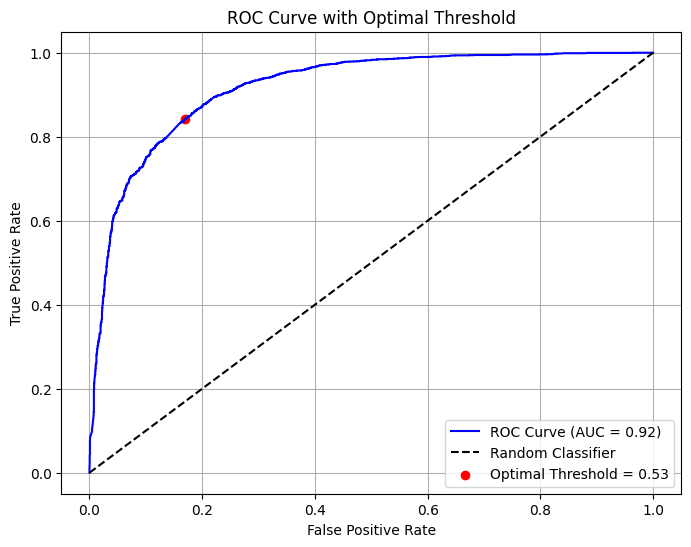

In [79]:
# Load sparse matrix from .npz properly
X_test = sparse.load_npz(r"splits arrays\x_test_best_tfidf.npz")

model_path = 'Logistic_regression_final.pkl'
tfidf_vectorizer_path = 'best_tfidf_vectorizer.pkl'

with open(model_path, 'rb') as model_file:
    model = pickle.load(model_file)

with open(tfidf_vectorizer_path, 'rb') as tfidf_file:
    tfidf_vectorizer = pickle.load(tfidf_file)

# Predict probabilities for positive class
y_probs = model.predict_proba(X_test)[:, 1]

# Compute AUC
auc_score = roc_auc_score(y_test, y_probs)
print(f"AUC Score: {auc_score:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Find optimal threshold (closest to top-left)
distances = np.sqrt((1 - tpr)**2 + fpr**2)
optimal_idx = np.argmin(distances)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"TPR at Optimal Threshold: {tpr[optimal_idx]:.4f}")
print(f"FPR at Optimal Threshold: {fpr[optimal_idx]:.4f}")

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.title("ROC Curve with Optimal Threshold")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()